***
## Predicting fuel consumption using machine learning for container ship - Case Study
#### <font color=green>*Ranjeet Sandhu*</font>
***

### Contents

- **Project and data overview**


- **Exploratory data analysis**
 - **Summary statistics** 
 - **Distributions**
 - **Correlation analysis**


- **Data cleaning and feature engineering**


- **Predictive modeling strategy**


- **Machine learning models' preformance analysis**


- **Model selection and tuning**


- **Conclusion and opportunities**

***

### Project and data overview

***

**Goal**: Predict the fuel consumption of ships for voyages to help ships operate at most efficient level.

**Objective**: Create a performance model of `LPG-VLGC` ship to predict the rate of fuel consumption on a set of features. The Machine Learning techniques are used to model the relationship across sensor, environmental data and fuel consumption rate. The trained hypotheses will be used to score a range of speeds and evaluate the predictive performance.

**Context**: Engine’s fuel cost is the major expenses for sea voyages; hence the accurate prediction is one of the prominent challenges in the maritime industry. The variability in the numerous operating and environmental factors impacting fuel consumption adds complexity to the issue; requiring a scientific problem-solving approach.

**Data**: The data are collected from a large `LPG-VLGC` ship’s sensors from `07-06-2017` to `05-14-2019`, which is down-sampled to the hourly records. The data has `16,248` samples containing the following features:

- Fuel consumption rate in metric tons per day. 
- Ship’s engine performance metrics such as shaft speed, shaft power and torque. Fuel type – heavy fuel or marine gas, former is used in open ocean and latter near coastal areas.
- Ship’s heading, rudder angle, speed, draft (how loaded is the ship).
- Environmental data such as wind speed, wind direction, temperature, etc.
- Sea state features such as sea current, wave height, wave period, etc.

**Import modules**

In [1]:
import numpy as np
import pandas as pd
from csv import reader
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [2]:
# Set global parameters
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
plt.style.use("ggplot")

In [3]:
def load_csv(filename):
    """
    Load data from a csv file 
    
    Parameters
    ----------
    filenanme: str
      Complete path of input dataset
    
    Returns
    -------
    List
      List of lists where each element represents a single record
    """
    dataset = list()
    with open(fileName, "r") as f:
        csv_reader = reader(f)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

**Import Raw Data**

The data is a list of lists where each list represents a data sample, converted to a pandas data frame.

In [4]:
fileName = '../data/raw/ship_data.csv'
dataset = load_csv(fileName)
print("Loaded data with {0} rows and {1} columns".format(len(dataset), len(dataset[0])))

# Convert to pandas dataframe
colNames = dataset[0]
df = pd.DataFrame(dataset[1:], columns=colNames)

Loaded data with 16249 rows and 26 columns


**1. Functions to convert unix timestamp to date-time object and re-index data frame <br> 2. Rename dataFrame columns to more readable names for easy referencing**

In [5]:
def time_index(data, col_ts, ts_units):
    """
    Convert unix ts to date-time and re-index data-frame 
    
    Parameters
    ----------
    data: Pandas DataFrame
      Input pandas data frame object
    col_ts: str
      Column name with timestamp data
    ts_units: str
      Units of the timestamp. This could be 's' as seconds, refer to documentation for more options.
    
    Returns
    -------
    DataFrame
      Pandas DataFrame object with dateTime index
    """
    data[col_ts] = pd.to_datetime(data[col_ts], unit=ts_units)
    data.set_index(col_ts, inplace=True)
    return data

def rename_cols(data, new_col_names):
    """
    Rename columns 
    """
    data.columns = new_col_names
    return data    

In [6]:
df = time_index(df, 'Time', 's')
new_col_names = ['fuelConsumption', 'HFO', 'MGO', 'draftForward', 'draftAft', 'draftMid1', 'draftMid2',
              'shaftSpeed', 'shaftTorque', 'shaftPower', 'speedGround', 'speedWater', 'heading', 'rudderAngle',
              'AWS', 'AWD', 'TWS', 'TWD', 'temp', 'currentDirection', 'currentSpeed', 'waterDepth', 'waveHeight',
              'wavePeriod', 'waveDirection']

df = rename_cols(df, new_col_names)

**DataFrame columns are imported as strings. There are empty string in the data representing missing values, which are replaced with NaN values and data types are set to float.**

In [7]:
df = df.replace(r'^\s*$', np.nan, regex=True).astype(np.float64)

***

### Exploratory data analysis

***

**Summary Statistics - key observations**

- `15` out of `24` features have missing values.


- `Fuel consumption`, `temperature` and `heading` features have negative values. `25th` percentile of fuel consumption is `-0.048` indicating there are about `25%` negative fuel values which is unexpected and needs investigation.


- Correlation metrics reflect high association between different draft values. 


- The engine output variables are also highly correlated. `Shaft power` is an output variable rather than input feature as it is not known beforehand.


- Feature correlations table shows the pearson correlation coefficient for association among features.


- Correlation heatmap `Fig1` is a visual representation of strength of association among variables. 


- `Rudder angle` and `temperature` show significant negative skewness.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16248 entries, 2017-07-06 13:15:00 to 2019-05-14 14:50:00
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fuelConsumption   16085 non-null  float64
 1   HFO               16085 non-null  float64
 2   MGO               16085 non-null  float64
 3   draftForward      16085 non-null  float64
 4   draftAft          16085 non-null  float64
 5   draftMid1         16085 non-null  float64
 6   draftMid2         16085 non-null  float64
 7   shaftSpeed        16085 non-null  float64
 8   shaftTorque       16085 non-null  float64
 9   shaftPower        16085 non-null  float64
 10  speedGround       16085 non-null  float64
 11  speedWater        16085 non-null  float64
 12  heading           16240 non-null  float64
 13  rudderAngle       16085 non-null  float64
 14  AWS               16248 non-null  float64
 15  AWD               16248 non-null  float64
 16  TWS  

In [9]:
pd.set_option('precision', 4)
description = df.describe()
description.iloc[:, :11]

,fuelConsumption,HFO,MGO,draftForward,draftAft,draftMid1,draftMid2,shaftSpeed,shaftTorque,shaftPower,speedGround
count,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000,16085.0000
mean,17.1799,0.8164,0.1742,8.0529,9.5256,8.7876,8.8871,50.9423,576.6316,4723.0028,9.3233
std,20.7597,0.3867,0.3788,2.6477,1.9165,2.2452,2.1067,36.6772,444.5160,4034.6219,6.5647
min,-22.5655,0.0000,0.0000,0.0000,0.0000,0.0000,5.6812,-7.1103,-0.0014,0.0000,0.0000
25%,-0.0480,1.0000,0.0000,5.7819,7.9499,6.8325,6.8541,0.0000,7.3894,6.9517,0.4347
50%,15.9220,1.0000,0.0000,7.2750,8.9124,8.1449,8.2967,69.7246,711.6736,5063.0435,12.3860
75%,39.7848,1.0000,0.0000,10.9297,11.5503,11.2648,11.3110,85.4579,1025.6620,9154.3486,15.1180
max,49.0908,1.0000,1.0000,13.1366,12.5892,12.1324,12.1279,88.9594,1206.0915,11150.0420,19.8449


**Feature correlations**

In [10]:
pd.set_option('precision', 3)
cols_to_drop = ['HFO', 'MGO', 'currentDirection', 'currentSpeed', 'waterDepth', 'waveHeight', 'wavePeriod', 
                'waveDirection']
correlations = df.drop(cols_to_drop, axis=1).corr(method='pearson')
correlations.iloc[:10, :11]

,fuelConsumption,draftForward,draftAft,draftMid1,draftMid2,shaftSpeed,shaftTorque,shaftPower,speedGround,speedWater,heading
fuelConsumption,1.000,0.164,0.224,0.185,0.157,0.729,0.773,0.799,0.728,0.728,0.062
draftForward,0.164,1.000,0.948,0.983,0.916,0.133,0.204,0.309,0.107,0.109,-0.099
draftAft,0.224,0.948,1.000,0.981,0.839,0.201,0.266,0.387,0.168,0.170,-0.085
draftMid1,0.185,0.983,0.981,1.000,0.893,0.147,0.220,0.333,0.113,0.115,-0.083
draftMid2,0.157,0.916,0.839,0.893,1.000,0.183,0.259,0.303,0.148,0.149,-0.132
shaftSpeed,0.729,0.133,0.201,0.147,0.183,1.000,0.980,0.931,0.989,0.992,-0.009
shaftTorque,0.773,0.204,0.266,0.220,0.259,0.980,1.000,0.975,0.964,0.966,-0.017
shaftPower,0.799,0.309,0.387,0.333,0.303,0.931,0.975,1.000,0.916,0.917,-0.014
speedGround,0.728,0.107,0.168,0.113,0.148,0.989,0.964,0.916,1.000,0.995,-0.005
speedWater,0.728,0.109,0.170,0.115,0.149,0.992,0.966,0.917,0.995,1.000,-0.003


**Correlation Heatmap**

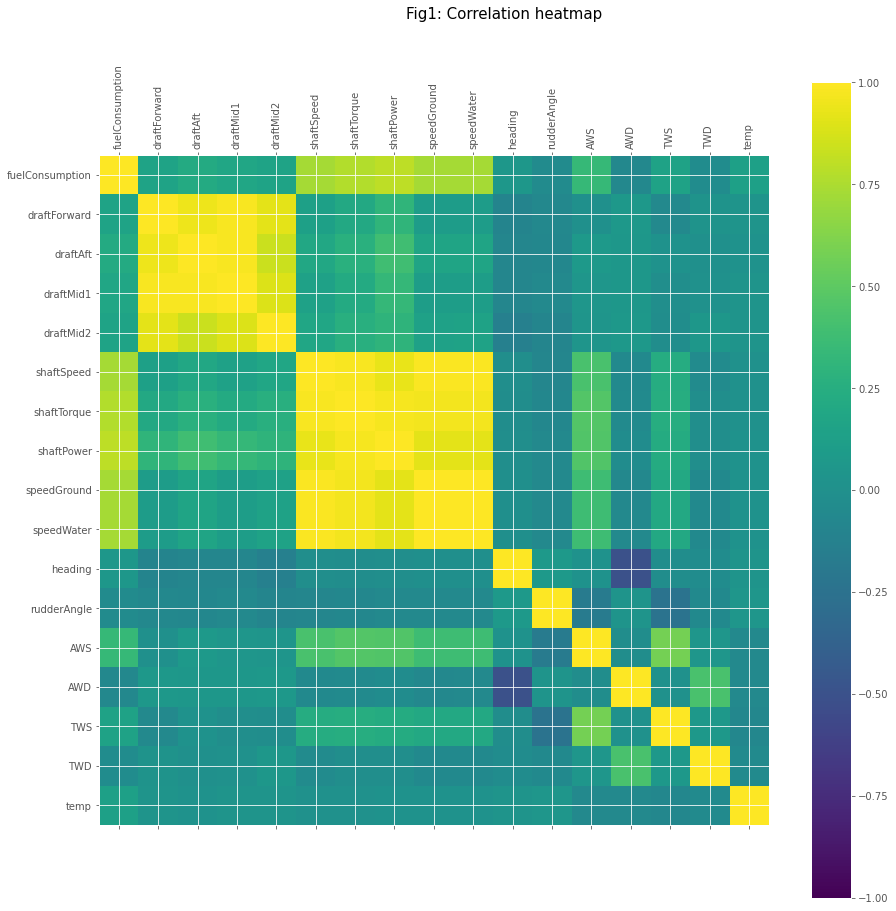

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,17,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.drop(cols_to_drop, axis=1).columns, rotation=90)
ax.set_yticklabels(df.drop(cols_to_drop, axis=1).columns);
fig.suptitle('Fig1: Correlation heatmap', size=15, y=0.95);

**Skewness of univariate distributions**

In [12]:
df.skew()

fuelConsumption     -0.129
HFO                 -1.635
MGO                  1.718
draftForward         0.049
draftAft            -0.647
draftMid1           -0.170
draftMid2            0.228
shaftSpeed          -0.520
shaftTorque         -0.215
shaftPower           0.059
speedGround         -0.492
speedWater          -0.509
heading             -0.226
rudderAngle         -2.726
AWS                  0.642
AWD                  0.393
TWS                  0.668
TWD                 -0.091
temp               -14.765
currentDirection     0.608
currentSpeed         3.054
waterDepth           3.458
waveHeight           3.095
wavePeriod           2.004
waveDirection        2.356
dtype: float64

**Distributions - Histograms and bar plots**

- `Fig2` shows the distributions of features. 


- Bimodal distributions are observed for draft, heading and speed features.


- Sea state features seem to be highly skewed with majority of the values as zero.


- `Fig3` shows missing values bar plot. There are 163 samples with `target variable` missing. 


- There are significant amount of zero values in the `sea-state` features - `Fig4`. These features therefore, don't contain any significant signal.

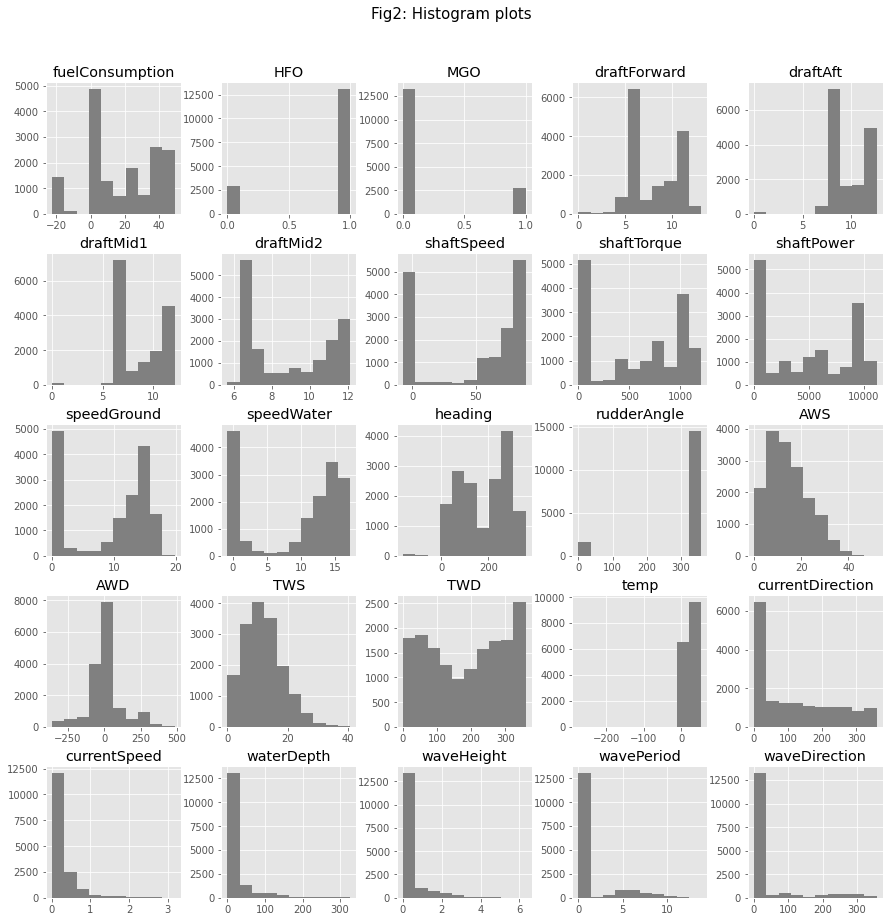

In [13]:
df.hist(color='gray')
plt.suptitle('Fig2: Histogram plots', size=15, y=0.95);

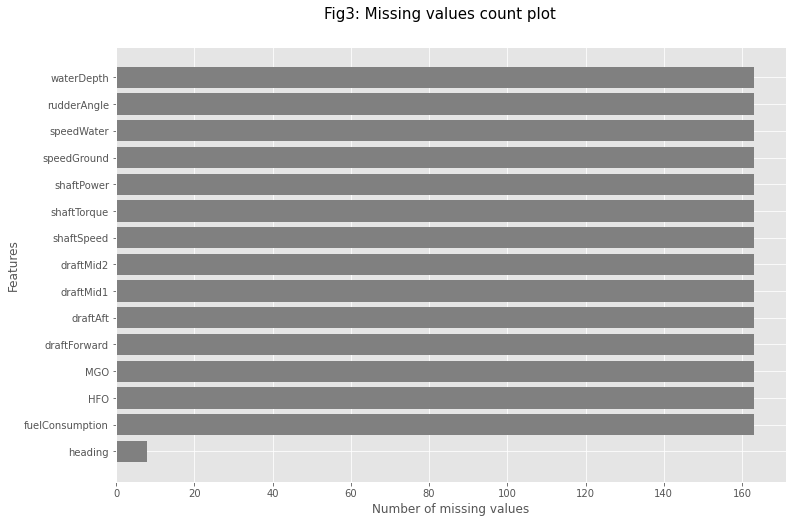

In [14]:
# Missing values count plot
nan_all = df.isna().sum()
missing = nan_all[nan_all != 0].sort_values()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(missing.index, missing.values, color='gray')
ax.set_xlabel("Number of missing values")
ax.set_ylabel("Features")
fig.suptitle('Fig3: Missing values count plot', size=15, y=0.95);

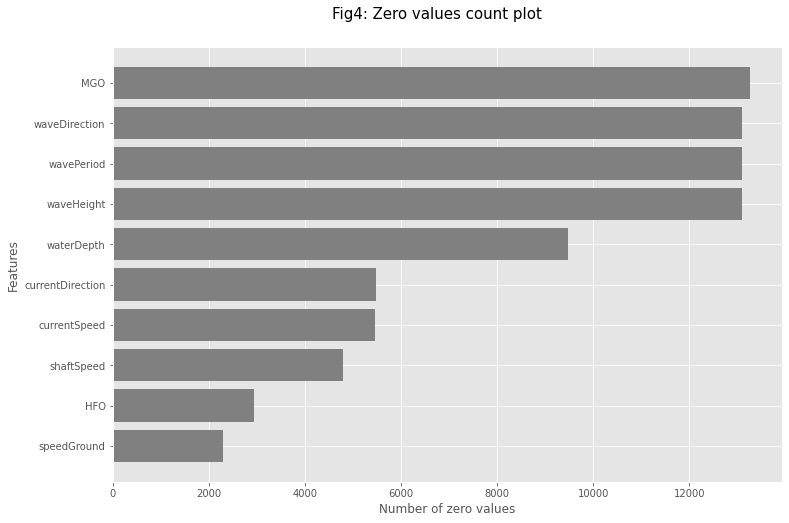

In [15]:
# Zero values counts plot
zeroCounts_all = (df == 0).sum().sort_values()
zeroCounts = zeroCounts_all[zeroCounts_all > 500]

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(zeroCounts.index, zeroCounts.values, color='gray')
ax.set_xlabel("Number of zero values")
ax.set_ylabel("Features")
fig.suptitle('Fig4: Zero values count plot', size=15, y=0.95);

***

### Data cleaning and feature engineering

***

- Null values `164` count are dropped from the dataset.


- `Mean draft` is calculated from all draft features (`draft aft`, `draft forward`, `draft mid1`, `draft mid2`).


- Since `MGO` is a complimentary redundant feature of `HFO`, hence it is dropped from study.


- `Speed in water` is chosen over speed on ground.


- Since `shaft power` is an engine output feature, it's not known beforehand, hence it is dropped.


- `True wind` features are selected over apparent wind features.


- `Shaft torque` is dropped as torque is a function of shaft speed and power.

In [16]:
# Drop null values and select features

df.dropna(how='any', inplace=True)

df['meanDraft'] = df[['draftAft', 'draftForward', 'draftMid1', 'draftMid2']].mean(axis=1)

cols_to_drop = ['MGO', 'draftForward', 'draftAft', 'draftMid1', 'draftMid2', 'shaftTorque', 'shaftPower',
                'speedGround', 'AWS', 'AWD', 'currentDirection', 'currentSpeed', 'waterDepth',
                'waveHeight', 'wavePeriod', 'waveDirection']

df.drop(columns=cols_to_drop, inplace=True)

**Data anomalies and outliers**

`Fig5` & `Fig6` are time series plots of key features. The plots reveal key insights about the data.

- `Fuel consumption` has `5,903` negative values out of `160,84` samples.


- `Temperature` shows `2` negative spikes below `200` degrees Celsius, which are found to be absolute temperature readings, likely cause due to sensor error (`24` such values indentified ).


- `Heading` is measured from magnetic north and varies between `0` & `360` degrees. There are `15` negative heading values.

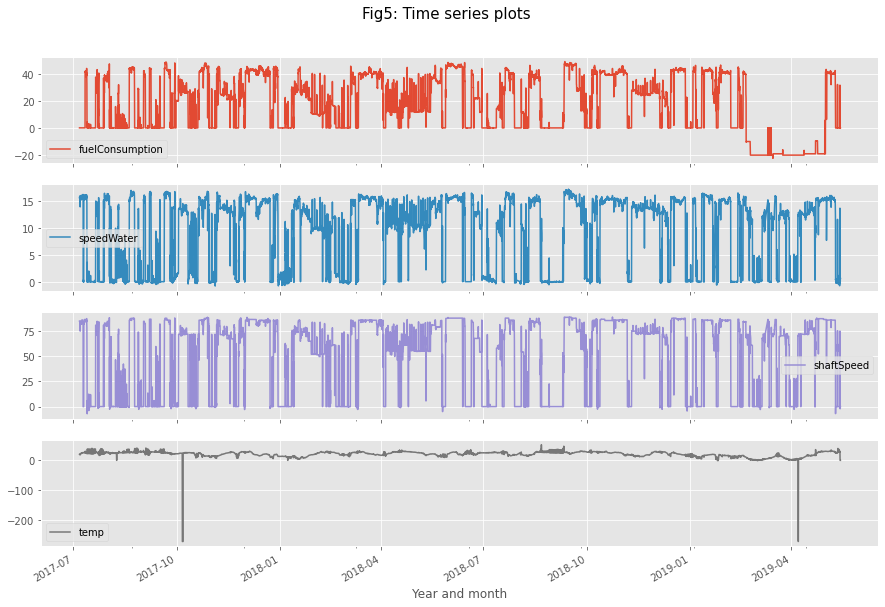

In [17]:
df.loc[:, ['fuelConsumption', 'speedWater', 'shaftSpeed', 'temp']].plot(subplots=True, figsize=(15, 10))
plt.xlabel("Year and month")
plt.suptitle('Fig5: Time series plots', size=15, y=0.95);

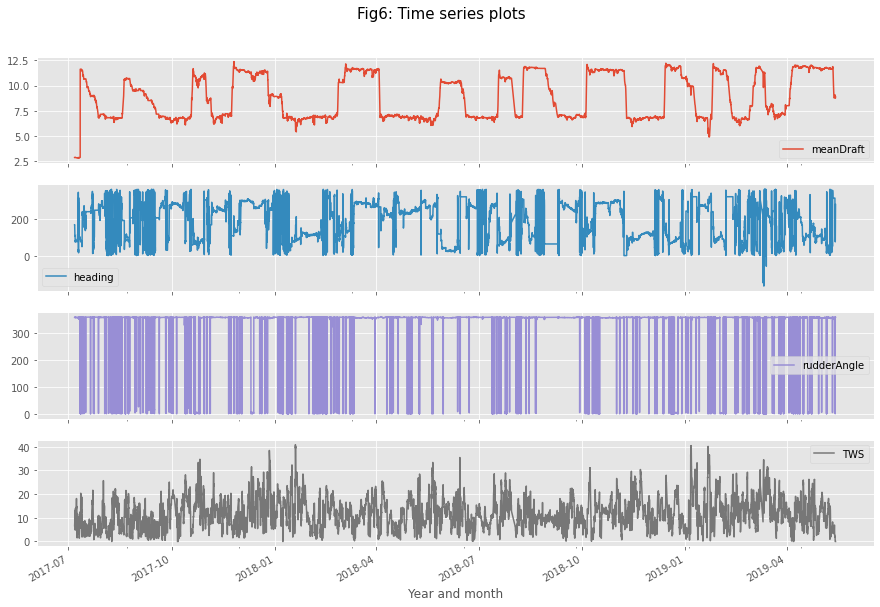

In [18]:
df.loc[:, ['meanDraft', 'heading', 'rudderAngle', 'TWS']].plot(subplots=True, figsize=(15, 10))
plt.xlabel("Year and month")
plt.suptitle('Fig6: Time series plots', size=15, y=0.95);

**Data Cleaning**

- `Fuel consumption` values less than `-0.5` are dropped (`1,580` samples). Since the fuel consumption should not be negative, these values are likely to be measurement errors. Negative fule consumption between `0` & `-0.5` (`4,323` samples) are set to zero as these values are likely to be within standard error of measurement. Since `shaft speed` is zero for these samples, it is inferred that the ship is docked at the port. Absolute zero `temperature` values and negative `heading` are erroneous values, hence dropped from the dataset.


- Final dataset for modeling has `14,476` samples. We retained about `89%` of the data after cleaning.


- `Summary statistics` are calculated before and after data manipulation to ensure the transformations are in line with the analysis, and data anomalies are addressed. The summary tables show that final dataset no more contains extreme negative values of `fuel consumption` and `temperature`.


- The tables also help in drawing inferences about data range, total count of missing values if any and measures of central tendency. The `50th` percentile corresponds to median of a numeric predictor. The metrics reflect that the mean and median are fairly close for each variable.

In [19]:
# Summary Statistics - before data cleaning
df.describe()

,fuelConsumption,HFO,shaftSpeed,speedWater,heading,rudderAngle,TWS,TWD,temp,meanDraft
count,16084.000,16084.000,16084.000,16084.000,16084.000,16084.000,16084.000,1.608e+04,16084.000,16084.000
mean,17.182,0.816,50.945,9.238,182.710,323.912,11.934,1.881e+02,20.735,8.813
std,20.758,0.387,36.676,6.549,102.050,105.071,6.385,1.131e+02,13.687,2.170
min,-22.566,0.000,-7.110,-0.812,-164.644,0.000,0.000,5.676e-04,-273.150,2.789
25%,-0.048,1.000,0.000,0.387,88.550,357.507,7.261,7.905e+01,16.451,6.840
50%,15.922,1.000,69.726,12.444,205.461,358.605,11.268,1.996e+02,22.683,8.090
75%,39.785,1.000,85.458,15.109,273.357,359.114,15.814,2.924e+02,26.867,11.304
max,49.091,1.000,88.959,17.187,359.824,359.999,40.846,3.600e+02,52.559,12.385


In [20]:
# Remove data anomalies
conditionEval = (df['heading'] < 0) | (df['temp'] < -273) | (df['fuelConsumption'] < -0.5)
df.drop(df[conditionEval].index, inplace=True)

df.loc[df['fuelConsumption'] < 0, 'fuelConsumption'] = 0

In [21]:
# Summary Statistics - after data cleaning
df.describe()

,fuelConsumption,HFO,shaftSpeed,speedWater,heading,rudderAngle,TWS,TWD,temp,meanDraft
count,14476.000,14476.000,14476.000,14476.000,14476.000,14476.000,14476.000,1.448e+04,14476.000,14476.000
mean,21.141,0.860,50.854,9.255,185.954,325.010,11.765,1.875e+02,22.349,8.734
std,17.856,0.346,36.942,6.610,101.859,103.479,6.379,1.138e+02,6.486,2.154
min,0.000,0.000,-7.110,-0.812,0.000,0.000,0.000,5.676e-04,-1.055,2.789
25%,0.000,1.000,0.000,0.399,89.916,357.465,7.071,7.832e+01,18.101,6.830
50%,22.258,1.000,69.021,12.563,214.588,358.596,11.005,1.969e+02,23.945,7.926
75%,40.218,1.000,85.516,15.183,275.985,359.110,15.636,2.935e+02,27.071,11.100
max,49.091,1.000,88.959,17.187,359.824,359.999,40.846,3.600e+02,52.559,12.385


**Scatter plots and histograms of final features - Interpretation**

- Diagonal of `Fig7` shows the univariate histograms of `fuel consumption`, `speed of ship in water`, `shaft rpm` and `temperature`. These data are plotted for `non-zero` fuel consumption to reflect the relationships when ship is in motion.


- `Speed of ship` in water and the `speed of shaft` show linear and slightly nonlinear relationship with `fuel consumption` respectively.


- High `temperature` values seem to associate with higher `fuel consumption`, which we shall explore further with more diagnostics.


- `Shaft speed` and `speed of ship` in water show a strong positive linear relation. A correlation matrix will give more insights into the strength of this relation.


- Distribution of `speed in water` and `shaft speed` show considerable skewness, which is expected as out data contains samples when the ship is either moored or docked at port.

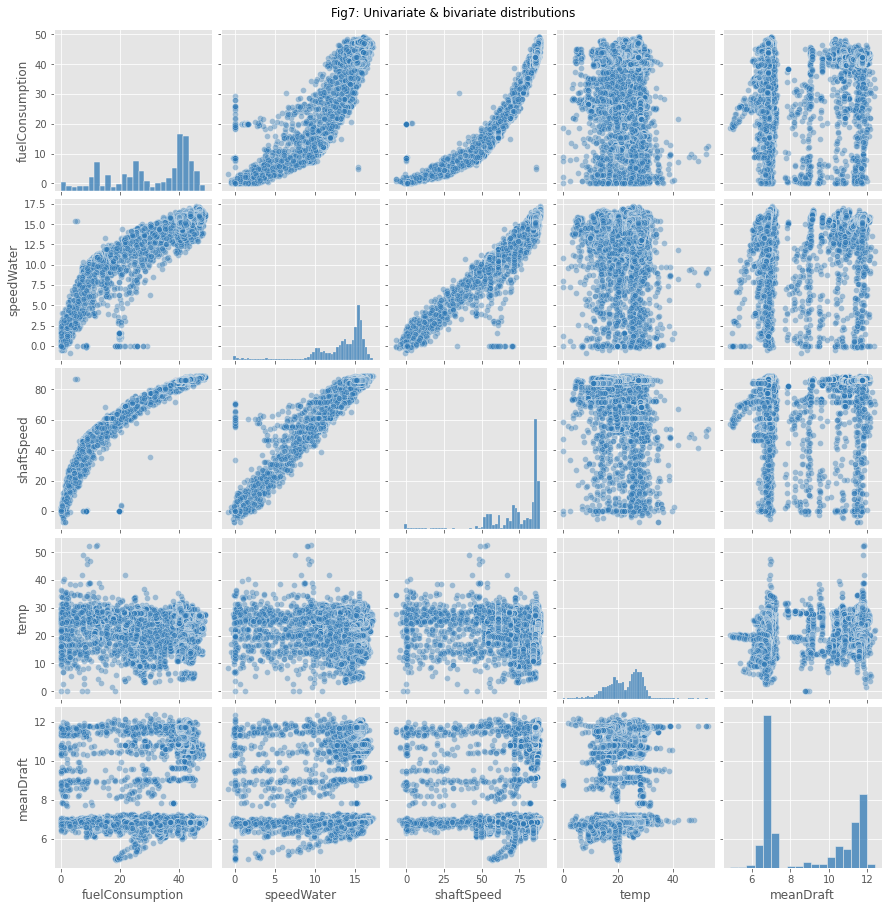

In [22]:
# Pair plot
sns.set_palette("RdBu_r")
g = sns.pairplot(df[df['fuelConsumption'] > 0], vars=['fuelConsumption', 'speedWater', 'shaftSpeed', 'temp', 'meanDraft'],
                 plot_kws={'alpha': 0.4})
g.fig.suptitle("Fig7: Univariate & bivariate distributions",  y=1.01);

**Correlation matrix of the feature space**

- `Fuel consumption` is highly correlated with `shaft speed` and `speed of ship` through water.


- `shaft speed` & `speed in water` are themselves highly correlated. The `linear regression` models (OLS) might end up with inflated or high variance parameters i.e., the model might not generalize well on unseen data. `Multi-collinearity` can be handled with regularization or using complex hypotheses. We shall investigate all these approaches.


- `Heading`, `rudder angle` and `wind direction` show negligible correlation with the `response` variable. we will retain all these variables for training our hypotheses.

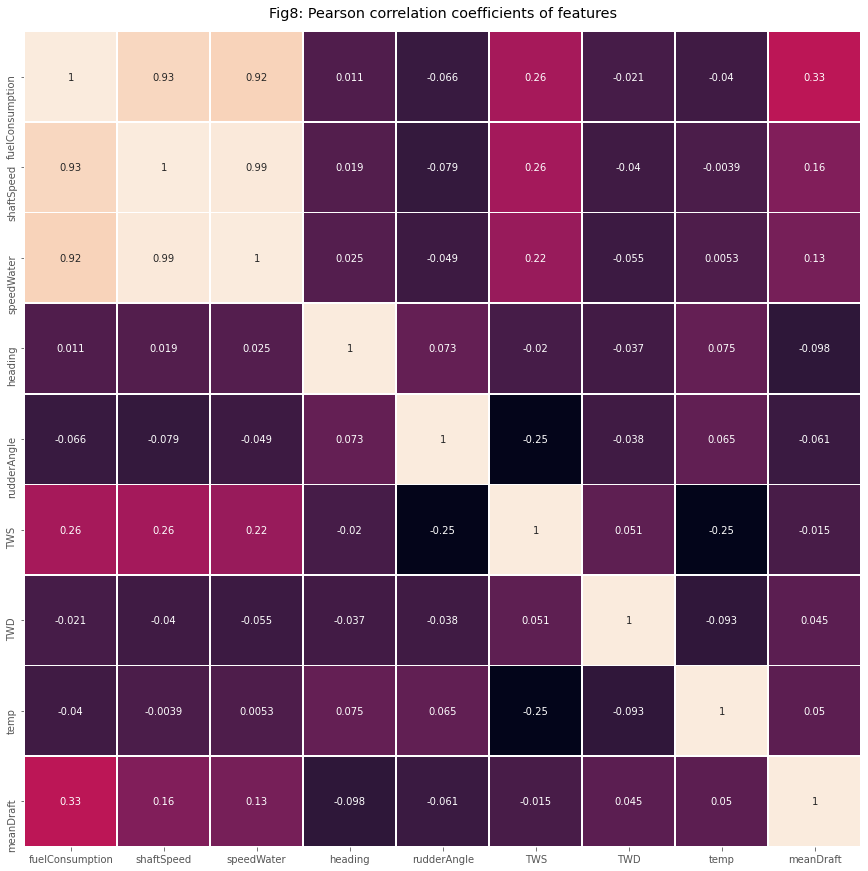

In [23]:
# Correlation Matrix
sns.heatmap(df.drop(columns='HFO').corr(), annot=True, cbar=False, linewidths=0.5)
plt.title("Fig8: Pearson correlation coefficients of features",  y=1.01);

***

### Predictive modeling strategy

***

- The `predictor space` consists of `9` features (`HFO`, `shaftSpeed`, `speedWater`, `heading`, `rudderAngle`, `TWS`, `TWD`, `temp` & `meanDraft`).


- There are `14,476` total number of `tidy data` samples for training, validating and scoring machine learning models. These samples are split into training and test data; training data consists of `11,580` (`80%`) and test data consists of `2,896` (`20%`) samples. Random state is set to reproduce the same data splits.


- Same `training` and `hold out` datasets are used for all machine learners.


- `10` fold `cross-validation` technique is used tune the model parameters.


- `Mean squared error` metric is used to evaluate and compare models' performance on test data.

In [24]:
# Split-out validation dataset
dataArray = df.values
X = dataArray[:, 1:10]
y = dataArray[:, 0]
validation_size = 0.2
seed = 1
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [25]:
# Test options and evaluation metric
num_folds = 10
seed = 1
scoring = 'neg_mean_squared_error'

***

### Machine Learning models and performance analysis

***

#### Spot check regression algorithms to discover which algorithms perform well on our use case.


- **Linear Algorithms:** Linear Regression (`LR`), Lasso Regression (`Lasso`) and ElasticNet (`EN`).


- **Nonlinear Algorithms:** Classification and Regression Trees (`CART`), k-Nearest Neighbors (`KNN`) and Support Vector Regression (`SVR`).


- The algorithms use default parameters.

In [26]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression())) 
models.append(('LASSO', Lasso())) 
models.append(('EN', ElasticNet())) 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('CART', DecisionTreeRegressor())) 
models.append(('SVR', SVR()))

- **`CART` has lowest `MSE` followed by `KNN`.** 


- **`Linear Regression` and its `penalized` variants show somewhat similar performance.**

In [27]:
# evaluate each model
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: -27.941384 (1.342601)
LASSO: -29.445360 (1.591052)
EN: -29.486938 (1.597735)
KNN: -7.240375 (1.778332)
CART: -1.235923 (0.616808)
SVR: -44.857756 (3.340361)


**Distribution of scores across all cross-validation folds by algorithm.**


- **`CART` scores shows much better and tight distribution as compared to other algorithms.**


- **`Linear regression` algorithms' scores show similar distribution.**


- **`SVR` seems to have a rather worse performance. This could be a result of features not being on similar scale.**

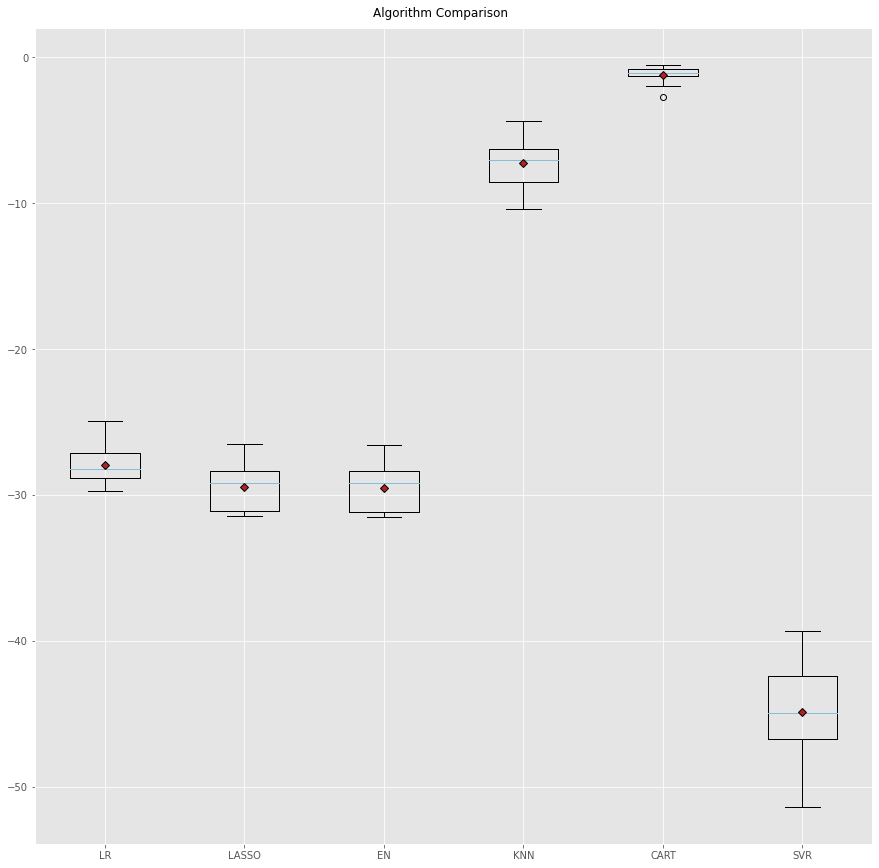

In [28]:
# Compare Algorithms
fig = plt.figure() 
fig.suptitle('Algorithm Comparison', y=.9) 
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
ax = fig.add_subplot(111) 
plt.boxplot(results, showmeans=True, meanprops=meanpointprops)
ax.set_xticklabels(names);

- The `differing scales` of the data may be negatively impacting the performance of the algorithms. Evaluate the algorithms again on `standardized` copy of the raw data.


- Data is transformed so that each feature has a `mean` values of `zero` and `standard deviation` of `1`.


- `Pipelines` are used to `standardize` the data and build the model for each fold in the cross-validation test. This helps in avoiding `data leakage` while transforming the data.

**Interpretation of scores on standardized dataset**

- `Standardization` had the most significant impact on the performance of `SVR` algorithms. 


- Performance of `KNN` shows improvement as well.


- `Linear regression` algorithms don't seem to show any performance improvement with standardization.

In [29]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())]))) 
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: -27.941384 (1.342601)
ScaledLASSO: -31.538014 (1.699536)
ScaledEN: -43.919407 (1.650595)
ScaledKNN: -4.842584 (0.768371)
ScaledCART: -1.266092 (0.724034)
ScaledSVR: -5.435085 (1.069193)


**Distribution of scores - Standardized data.**


- **`CART` and `KNN` scores shows much better and tight distribution as compared to other algorithms.**


- **`SVR` seems to show good performance on validation datasets.**


- **`ElasticNet` algorithm's performace is worse as compared to pre-standardization.**

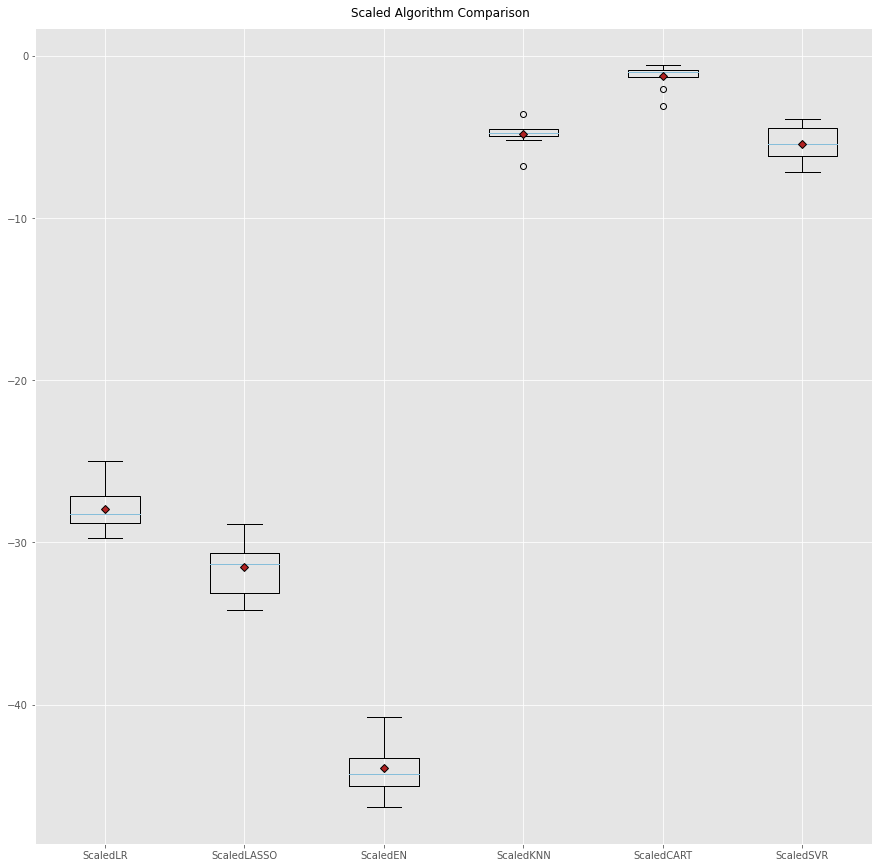

In [30]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison', y=.9) 
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick') 
ax = fig.add_subplot(111) 
plt.boxplot(results, showmeans=True, meanprops=meanpointprops) 
ax.set_xticklabels(names);

**Ensemble Models**


- Evaluating emsemble models to improve the performance of algorithms. `4` emsemble methods are used with `10` fold cross-validation for performance evaluation.


- **Boosting Methods:** AdaBoost (`AB`) and Gradient Boosting (`GBM`)


- **Bagging Methods:** Random Forests (`RF`) and Extra Trees (`ET`)


- Default parameters are used for each method. `Number of estimators` for both `bagging` methods are fixed at `10`.


- `n_jobs` parameters is set to run the number of jobs in parallel and it is dependent on the resources available.


- `Ensemble methods` show better performance than `linear` and `non linear` algorithms, as shown by the `mean squared errors` obtained from cross-validation results.

In [31]:
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))]))) 
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))])))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -12.974374 (3.136843)
ScaledGBM: -1.492289 (0.635590)
ScaledRF: -0.901236 (0.689948)
ScaledET: -0.825610 (0.649186)


**Distribution of scores across the cross-validation folds - Ensembles.**


- **`Random Forest` and `Extra Trees` have better mean scores and it also looks like `Extra Trees` has marginally better mean and median scores, and a comparatively tighter distribution.**


- **Since, the emsembles used the default parameters, we will tune the `Extra Trees` ensemble model to further lift the performance.** 

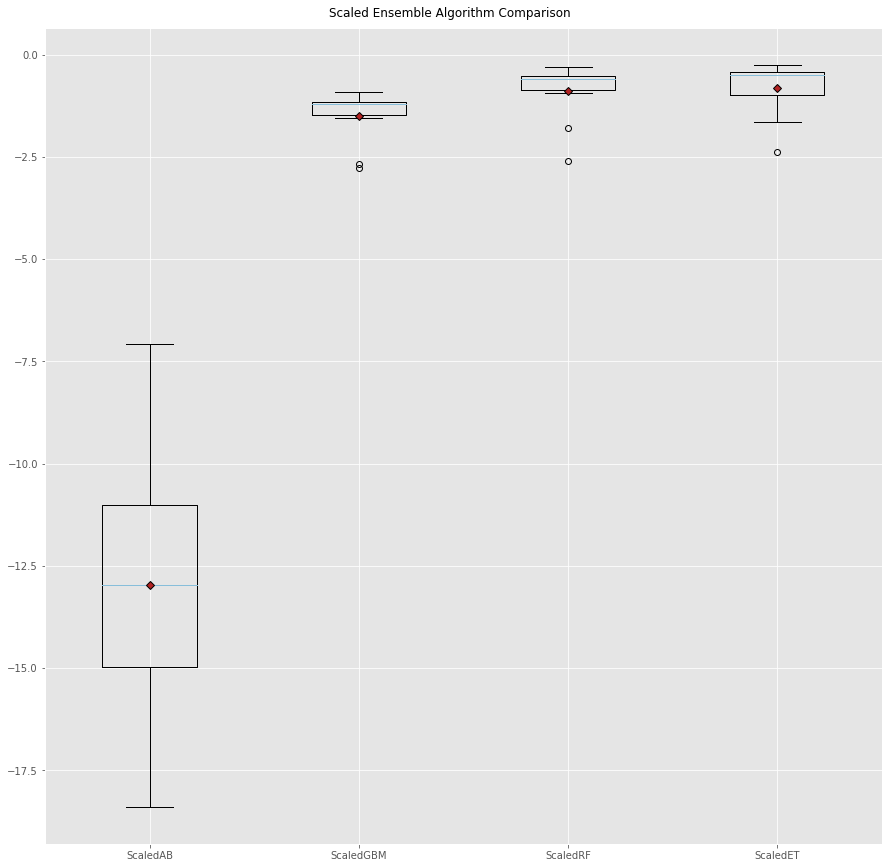

In [32]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison', y=.9) 
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick') 
ax = fig.add_subplot(111)
plt.boxplot(results, showmeans=True, meanprops=meanpointprops)
ax.set_xticklabels(names);

***

### Model selection and hyper-parameter tuning

***

**Explore Number of trees and evaluate performance**

- The default number of trees in the `Extra Trees` regressor is `100`. We will tune the number of trees over a range of `n_estimators` and evaluate the optimal number. 


- Each setting is evaluated on cross-validation evaluation dataset using `10` fold cross validation.

In [33]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 300, 500, 1000, 1500, 2000]
    for n in n_trees:
        models[str(n)] = ExtraTreesRegressor(n_estimators=n)
    return models

models = get_models()

In [34]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

10: -0.826727 (0.657770)
50: -0.735063 (0.564173)
100: -0.700296 (0.572526)
300: -0.699903 (0.567222)
500: -0.697395 (0.563429)
1000: -0.697516 (0.567151)
1500: -0.695038 (0.565384)
2000: -0.697832 (0.569763)


**Parameter and performance interpretation**

- Performance based on `mean squared error` steadily increases till number of trees reach `100` and doesn't show any significant improvement for larger number of trees.


- As the number of trees become large, the algorithm becomes computationally intensive. We will consider `100` trees as optimal for the final model.

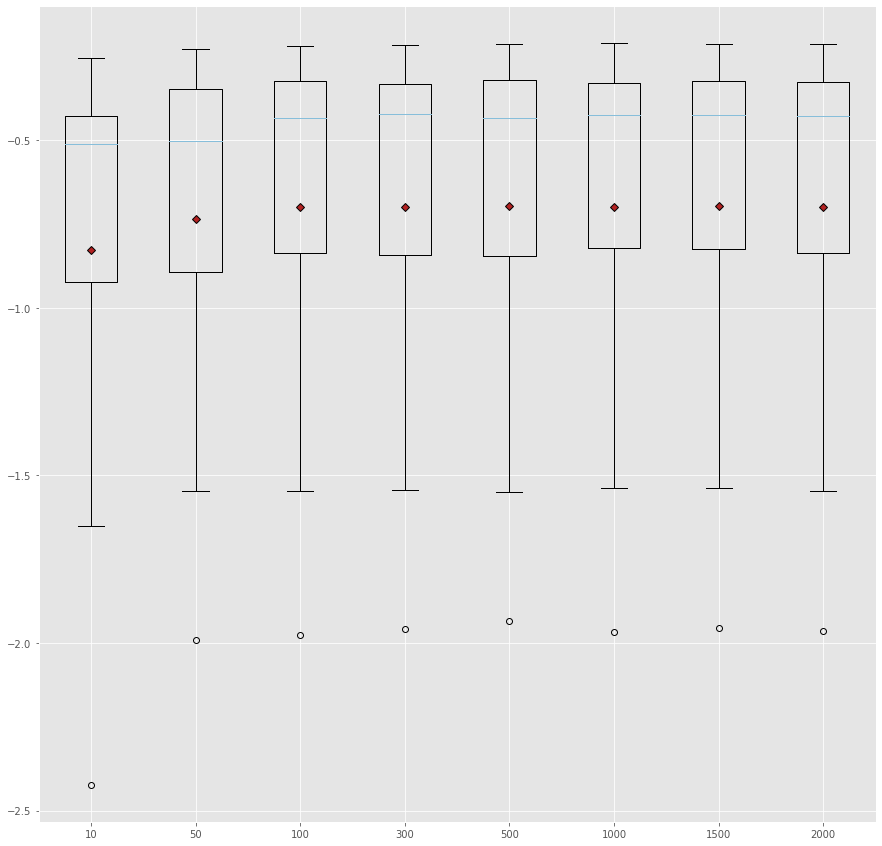

In [35]:
# plot model performance for comparison
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick') 

plt.boxplot(results, labels=names, showmeans=True, meanprops=meanpointprops);

**Explore number of features**

The default `number of features` to consider for split is the whole feature space. We will tune and evaluate this parameter over a range of values from `1` to `8` and evaluate the optimal number of features.

In [36]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # Explore number of features to consider from 1 to 8
    for i in range(1, rescaledX.shape[1]):
        models[str(i)] = ExtraTreesRegressor(max_features=i)
    return models

models = get_models()

In [37]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

1: -1.415145 (0.461386)
2: -0.926753 (0.501166)
3: -0.763279 (0.494899)
4: -0.712111 (0.522787)
5: -0.682707 (0.521920)
6: -0.692502 (0.537868)
7: -0.682229 (0.531358)
8: -0.693930 (0.539321)


**Number of features - parameter and performance interpretation**

- Performance increases upto `number of features` reach `5`, levels off after that and then decreases beyond that point.


- Optimal performance is achieved when `number of features` are `5`. Increasing number of features don't necessarily optimize performance. A slight deviation from these numbers might be observed considering the random behaviour of the algorithm in feature selection.

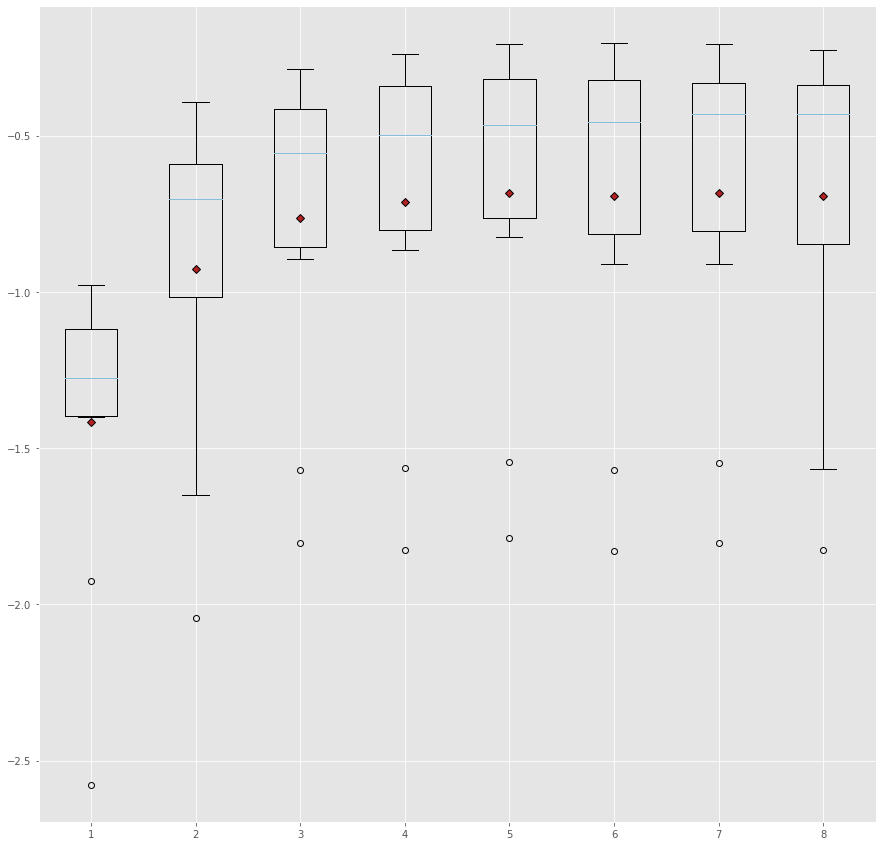

In [38]:
# plot model performance for comparison
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick') 

plt.boxplot(results, labels=names, showmeans=True, meanprops=meanpointprops);

**Explore minimum samples per split**

The default `minimum samples in a split` is `2`. This refers to minimum number of samples required to split an internal node. This parameter is tuned over a range from `2` to `8`. 

In [39]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # Explore minimum samples per split from 2 to 8
    for i in range(2, 9):
        models[str(i)] = ExtraTreesRegressor(min_samples_split=i)
    return models

models = get_models()

In [40]:
results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

2: -0.702187 (0.568868)
3: -0.701984 (0.574909)
4: -0.708594 (0.571253)
5: -0.722614 (0.556762)
6: -0.728006 (0.584580)
7: -0.714846 (0.578144)
8: -0.729866 (0.572577)


**Minimum number of samples per split - parameter and performance interpretation**

- Performance increases upto `number of features` reach `5`, levels off after that and then decreases beyond that point.


- Optimal performance is achieved when `number of features` are `5`. Increasing number of features don't necessarily optimize performance. A slight deviation from these numbers might be observed considering the random behaviour of the algorithm in feature selection.

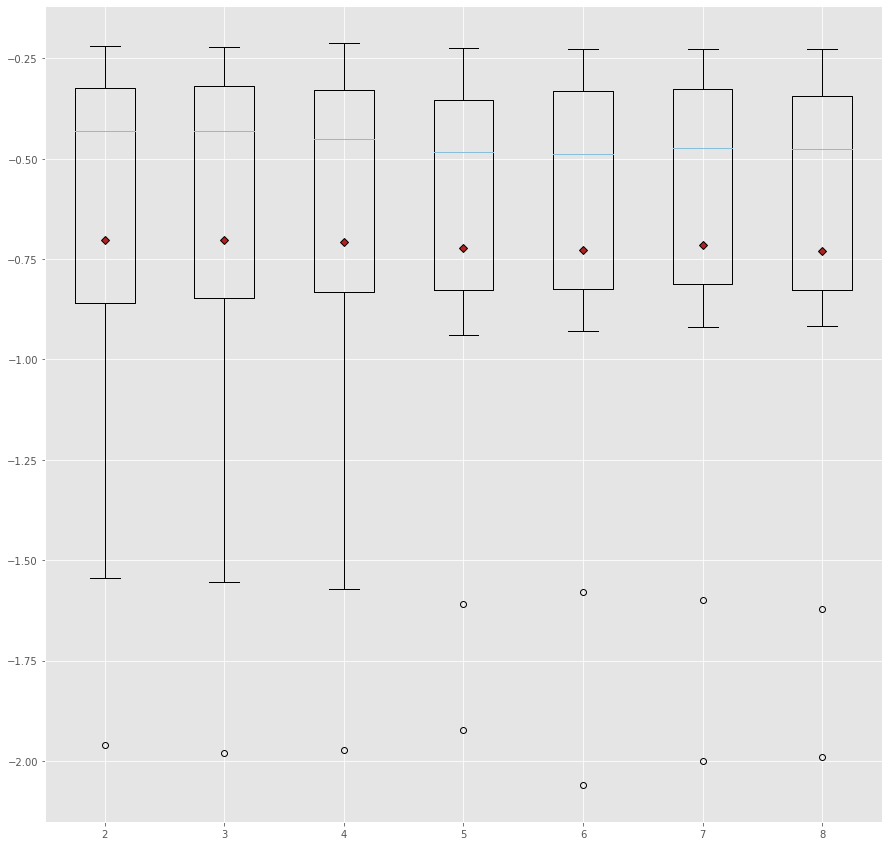

In [41]:
# plot model performance for comparison
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick') 

plt.boxplot(results, labels=names, showmeans=True, meanprops=meanpointprops);

<h4><center> Table of hyperparameters tuned for Extra Trees Regressor </center></h4>

| **Extra Trees hyper-parameters (Tuned)** | **Tuning values** | **Best model hyper-parameters** | **Optimal RMSE**
| :--------------------------------------: | :---------------: | :-----------------------------: | :--------------: 
| **n_estimator** | **[ 10, 50, 100, 300, 500, 1000, 1500, 2000 ]** | **100** | **0.710855**
| **max_features** | **[ 1, 2, 3, 4, 5, 6, 7, 8 ]** | **5** | **0.677712**
| **min_samples_split** | **[ 1, 2, 3, 4, 5, 6, 7, 8 ]** | **4** | **0.705608**

#### Final Model

- **`Extra Trees Regressor` with tuned hyper-parameters is selected as `candidate model` and again fit to the whole `standardized` training dataset.**


- **`Model` is evaluated on hold out `standardized` test dataset.**


- **The `mean squared error` obtained is `0.909` indicating that the model's performance is not far off from the cross validation results. The hyper-parameter tuning clearly lifted the performance and the model is expected to perform well on new data.**


- **Based on the cross-validation results and model's performance on hold out test data, it can be inferred that the model didn't `underfit` or `overfit` the training data.** 

In [42]:
# prepare the model
model = ExtraTreesRegressor(random_state=seed, 
                            n_estimators=100, 
                            max_features=5, 
                            min_samples_split=4, 
                            n_jobs=14)
model.fit(rescaledX, y_train)

ExtraTreesRegressor(max_features=5, min_samples_split=4, n_jobs=14,
                    random_state=1)

In [43]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(y_validation, predictions))

0.9095871479611014


**Feature Importances**

- As shown in the plot below `shaft speed` and `speed of ship` in water are the most important features.


- `Mean draft` and `type of fuel` are next most important features in determining the fuel consumption rate

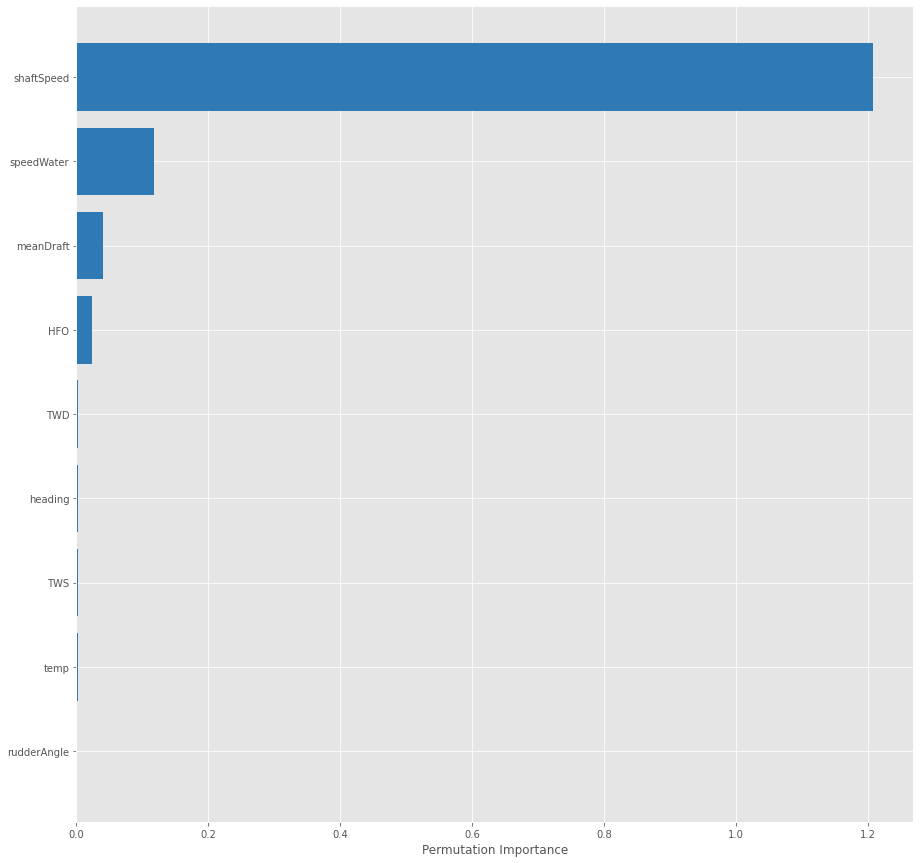

In [44]:
feature_names = df.columns[1:]
perm_importance = permutation_importance(model, rescaledValidationX, y_validation)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

***

### Conclusion & Opportunities

***

### Conclusion:

- **Extra Trees Regression model, with tuned hyper-parameters has outperformed the other models which were tested during this experiment. Performance of the model on unseen data as indicated by Root Mean Square Error is 0.909**


- **Top contributing factors for fuel consumption rate are shaft speed, speed of ship in water, mean draft and type of fuel.**


- **The root mean squared error evaluation scores observed during model training using cross-validation is superior to similar scores obtained from other models.**


- **The model can be scored on a range of perdictor values to estimate the fuel consumption rate for this ship. However, the generalization of this model to predict fuel consumption rate for other ships will require further analysis.**


### Opportunities:

- **The data from multiple ships and voyages can help in generalization of the model.**


- **Information about sea water salinity and the course of ship can help in further enhancing the predictive performance of the model.**


- **Ship’s maintenance data may provide further insights into ship’s working condition and its impact on fuel consumption.**


- **The outliers and erroneous data negatively impact the model’s predictive performance which can be mitigated by investigating the source and reason for data quality issues.**